In [0]:
!pip install gdal
!pip install rasterio
!pip install eo-learn
!pip install sentinelhub

     |████████████████████████████████| 19.7MB 2.7MB/s 
     |████████████████████████████████| 901kB 8.1MB/s 
     |████████████████████████████████| 71kB 28.0MB/s 
     |████████████████████████████████| 26.1MB 64.5MB/s 
     |████████████████████████████████| 22.4MB 56.4MB/s 
     |████████████████████████████████| 17.9MB 43.4MB/s 
     |████████████████████████████████| 10.8MB 51.1MB/s 
     |████████████████████████████████| 133kB 53.1MB/s 
     |████████████████████████████████| 51kB 24.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/91/4d/a4/7edb197fc9275482c0920a96eada1118751468cbb0ea31d250
  Stored in directory: /root/.cache/pip/wheels/73/83/af/e1beb4a24d7f34ef8a9d41277e0a5d0f8c9f0a1c836404844c
  Stored in directory: /root/.cache/pip/wheels/7f/2d/21/2fd3128af080f0459f7d1a51ac00627f0baf824039cb8bad18
  Stored in directory: /root/.cache/pip/wheels/55/fe/ac/e7e3cf444be38847d903299142b576b5db36bad6e6e2de10e0
  Stored in directory: /root/.cache/pip/wheels/ed/af/de/9026ee1fc01

In [0]:
import os
from os import path as op
import itertools

from eolearn.io import *
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, SaveToDisk, OverwritePermission
from sentinelhub import BBox, CRS, BBoxSplitter, MimeType, ServiceType

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import geopandas

from eolearn.features import LinearInterpolation

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
K.clear_session()

In [0]:
time_interval = ('2017-01-01', '2017-12-31')
img_width = 256
img_height = 256
maxcc = 0.2

In [0]:
from google.colab import files
crs = CRS.UTM_33N
aoi = geopandas.read_file('svn_buffered.geojson')
aoi = aoi.to_crs(crs={'init':CRS.ogc_string(crs)})
aoi_shape = aoi.geometry.values.tolist()[-1]

bbox_splitter = BBoxSplitter([aoi_shape], crs, (25, 17))

In [0]:

import pandas as pd
from shapely.geometry import Polygon

ID = 190
bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())


patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and            
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)


patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3,3))).ravel()          
    

geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]
df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = geopandas.GeoDataFrame(df, 
                       crs={'init':CRS.ogc_string(crs)}, 
                       geometry=geometry)

In [0]:

class MedianPixel(EOTask):

    def __init__(self, feature, feature_out):
        self.feature_type, self.feature_name = next(self._parse_features(feature)())
        self.feature_type_out, self.feature_name_out = next(self._parse_features(feature_out)())

    def execute(self, eopatch):
        eopatch.add_feature(self.feature_type_out, self.feature_name_out, 
                            np.median(eopatch[self.feature_type][self.feature_name], axis=0))
        return eopatch

In [0]:

input_task = S2L2AWCSInput('TRUE-COLOR-S2-L2A', resx='10m', resy='10m', maxcc=0.2, instance_id = '81d2e66c-79b3-454c-9fb4-1b9def06eb22')


get_median_pixel = MedianPixel((FeatureType.DATA, 'TRUE-COLOR-S2-L2A'), 
                               feature_out=(FeatureType.DATA_TIMELESS, 'MEDIAN_PIXEL'))

save = SaveToDisk(op.join('data', 'eopatch'), 
                  overwrite_permission=OverwritePermission.OVERWRITE_PATCH, 
                  compress_level=2)

In [0]:
file1 = files.upload()


Saving raba_subset_large.cpg to raba_subset_large.cpg
Saving raba_subset_large.dbf to raba_subset_large.dbf
Saving raba_subset_large.prj to raba_subset_large.prj
Saving raba_subset_large.shp to raba_subset_large.shp


In [0]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch

In [0]:
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask

cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m', 
                           cmask_feature='CLM', 
                           cprobs_feature='CLP',
                           instance_id = '81d2e66c-79b3-454c-9fb4-1b9def06eb22'
                          )
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' 
                                     )


count_val_sh = CountValid('IS_VALID', 
                          'VALID_COUNT' 
                         )

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
from eolearn.geometry import VectorToRaster, PointSamplingTask
raba = geopandas.read_file('raba_subset_large.shp')

raba_val = [0,1,2,3,4,5,6,7,8,9,10]
raba_array = []
for val in raba_val:
    temp = raba[raba.lulcid==val]
    temp.reset_index(drop=True, inplace=True)
    raba_array.append(temp)
    del temp
    
rshape = (FeatureType.MASK, 'IS_VALID')

raba_task_array = []
for el, val in zip(raba_array, raba_val):
    raba_task_array.append(VectorToRaster(
        feature=(FeatureType.MASK_TIMELESS, 'LULC'), 
        vector_data=el,
        raster_value=val, 
        raster_shape=rshape,
        raster_dtype=np.uint8))

In [0]:

workflow = LinearWorkflow(
    input_task,
    add_clm,
    add_sh_valmask,
    count_val_sh,
    get_median_pixel,
    *raba_task_array
)

In [0]:
poly = gdf['geometry'][0]
x1,y1,x2,y2 = poly.bounds
aspect_ratio = (y1-y2)/(x1-x2)

In [0]:
eopatches = [] 
time_interval = ['2017-04-01','2017-07-31'] 

for idx, bbox in enumerate(bbox_list[patchIDs]):
    # define additional parameters of the workflow
    extra_param = {input_task:{'bbox':bbox, 'time_interval':time_interval}}
    result = workflow.execute(extra_param)    
    eopatches.append(result[list(result.keys())[-1]])

In [0]:
file2 = files.upload()

Saving lulc_classes.py to lulc_classes.py
Saving lulc_cmap.py to lulc_cmap.py


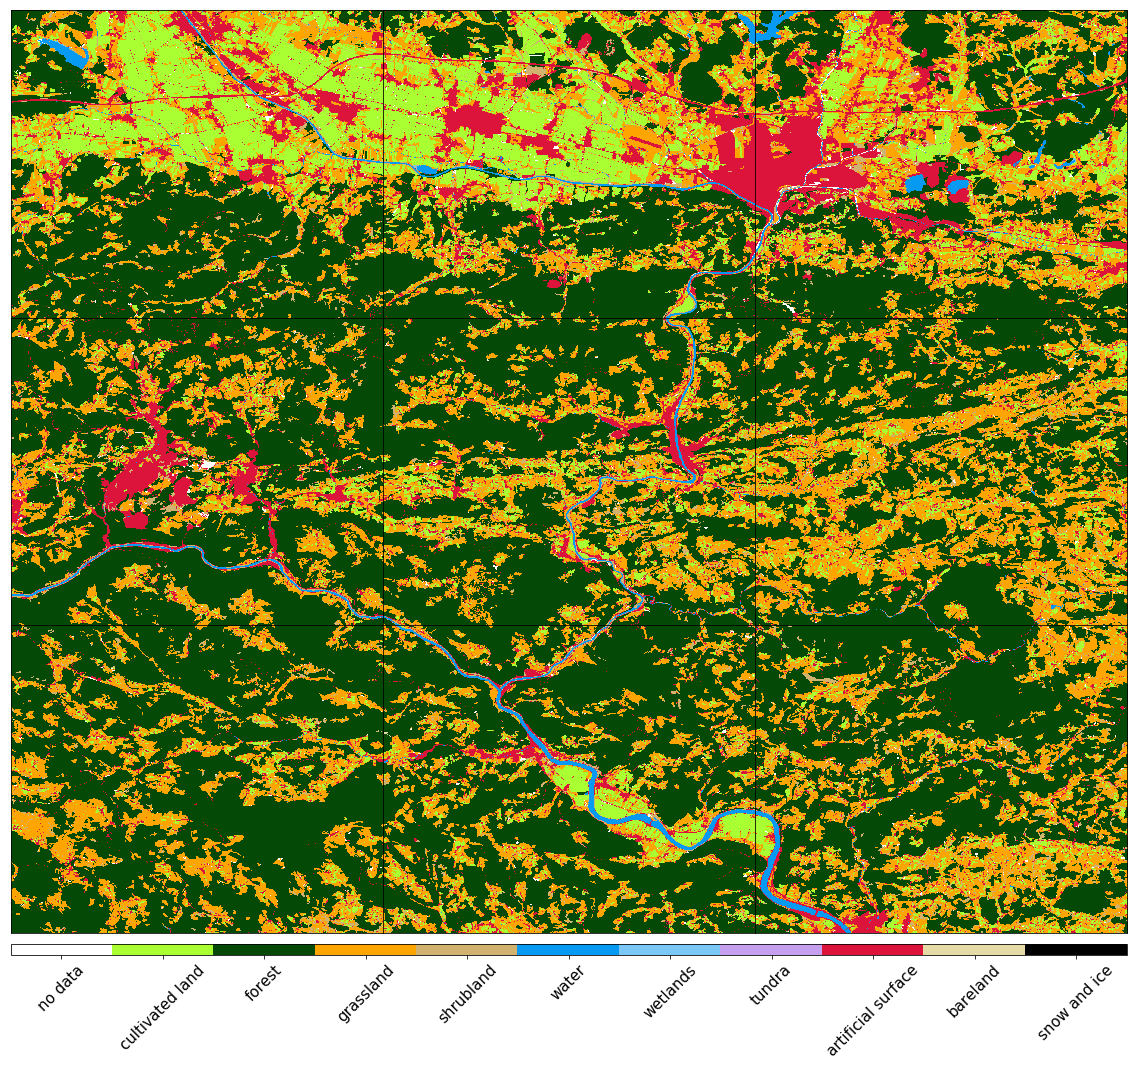

In [0]:

from lulc_cmap import lulc_cmap, lulc_norm
from lulc_classes import lulc_classes

fig, axes = plt.subplots(figsize=(20,20*aspect_ratio), nrows=3, ncols=3)
                                                                
for i, ax in enumerate(axes.flat):
    eopatch = eopatches[i]
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad = 0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks(np.array(list(lulc_classes.values())))
cb.ax.set_xticklabels(list(lulc_classes.keys()),rotation=45,fontsize=15)
plt.show()

In [0]:
img_height = 256
img_width = 256
x_train_raw = np.empty((80, img_height, img_width, 3))
y_train_raw = np.empty((80, img_height, img_width, 1))
k=0
#pixels = [0, 128,256,384,512,640,768,896]
pixels = [0,256,512,768]

for idx in range(0, 9):
    for i in range(0,3):
        for j in range(0,3):
        #print(k)
            if np.mean(eopatches[idx].data_timeless['MEDIAN_PIXEL'][pixels[i]:pixels[i+1],pixels[j]:pixels[j+1],:])>0.03:
                x_train_raw[k] = eopatches[idx].data_timeless['MEDIAN_PIXEL'][pixels[i]:pixels[i+1],pixels[j]:pixels[j+1],:]
                y_train_raw[k] = eopatches[idx].mask_timeless['LULC'][pixels[i]:pixels[i+1],pixels[j]:pixels[j+1],:] 
                k+=1
print(k)
img_mean = np.mean(x_train_raw, axis=(0, 1, 2))
img_std = np.std(x_train_raw, axis=(0, 1, 2))
x_train_raw = x_train_raw + img_mean - img_std
#x_train_mean = x_train_raw - img_mean

#x_train = x_train_raw[:399]
#x_train = np.vstack((x_train[0:21,:,:],x_train[24:,:,:]))
#x_train = np.vstack((x_train[0:39,:,:],x_train[41:,:,:]))
#x_train = x_train[6:,:,:]
#y_train = y_train_raw[:399]
#y_train = np.vstack((y_train[0:21,:,:],y_train[24:,:,:]))
#y_train = np.vstack((y_train[0:39,:,:],y_train[41:,:,:]))
#y_train = y_train[6:,:,:]



80


In [0]:
img_height = 256
img_width = 256
x_train_raw = np.empty((72, img_height, img_width, 3))
y_train_raw = np.empty((72, img_height, img_width, 1))
k=0
pixels = [0,256,512,768]
#pixels = [0,256,512,768]

for idx in range(0, 9):
    for i in range(0,3):
        for j in range(0,3):
        #print(k)
            if np.mean(eopatches[idx].data_timeless['MEDIAN_PIXEL'][pixels[i]:pixels[i+1],pixels[j]:pixels[j+1],:])>0.03:
                x_train_raw[k] = eopatches[idx].data_timeless['MEDIAN_PIXEL'][pixels[i]:pixels[i+1],pixels[j]:pixels[j+1],:]
                y_train_raw[k] = eopatches[idx].mask_timeless['LULC'][pixels[i]:pixels[i+1],pixels[j]:pixels[j+1],:] 
                k+=1
        #pbar.update(1)
print(k)

72


In [0]:
img_height = 64
img_width = 64
x_train_raw = np.empty((2004, img_height, img_width, 3))
y_train_raw = np.empty((2004, img_height, img_width, 1))
k=0
pixels = [0,64, 128,192, 256,320,384,448,512,576,640,704,768,832,896,960]
#pixels = [0,256,512,768]

for idx in range(0, 9):
    for i in range(0,15):
        for j in range(0,15):
        #print(k)
            if np.mean(eopatches[idx].data_timeless['MEDIAN_PIXEL'][pixels[i]:pixels[i+1],pixels[j]:pixels[j+1],:])>0.03:
                x_train_raw[k] = eopatches[idx].data_timeless['MEDIAN_PIXEL'][pixels[i]:pixels[i+1],pixels[j]:pixels[j+1],:]
                y_train_raw[k] = eopatches[idx].mask_timeless['LULC'][pixels[i]:pixels[i+1],pixels[j]:pixels[j+1],:] 
                k+=1
        #pbar.update(1)
img_mean = np.mean(x_train_raw, axis=(0, 1, 2))
img_std = np.std(x_train_raw, axis=(0, 1, 2))
x_train_raw = x_train_raw + img_mean - img_std
print(k)

2004


In [0]:
y_train_raw[y_train_raw == 0] = 2
#y_train_raw[y_train_raw == 6] = 5
#y_train_raw[y_train_raw == 7] = 5
#y_train_raw[y_train_raw == 9] = 2
#y_train_raw[y_train_raw == 10] = 5

#y_train_raw[y_train_raw == 1] = 0
#y_train_raw[y_train_raw == 2] = 1
#y_train_raw[y_train_raw == 3] = 2
#y_train_raw[y_train_raw == 4] = 3
#y_train_raw[y_train_raw == 5] = 4
#y_train_raw[y_train_raw == 8] = 5




In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train_raw, y_train_raw, test_size=0.1, random_state=42)

In [0]:

train_gen = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    validation_split = 0.15)



y_train = to_categorical(y_train)

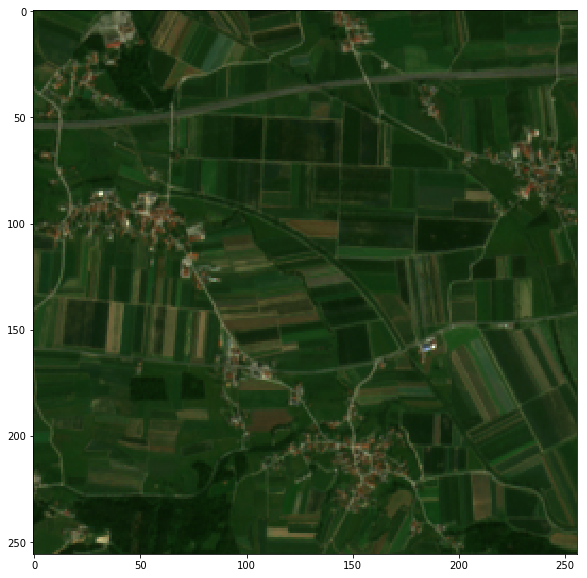

In [0]:
idx=0
mp = x_train[idx]
#- np.mean(x_train_raw[29]) + np.std(x_train_raw)#9,10,18  #39,40, 21,22, 23,
plt.figure(figsize=(10,10))
plt.imshow(mp)

In [0]:
del model


In [0]:
  
def unet(input_size):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(10, 1, activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(loss='categorical_crossentropy',
            optimizer='adadelta', metrics=["accuracy"])

    return model

model = unet(input_size=(64, 64, 3))

In [0]:
batch_size = 50
model.fit_generator(
        train_gen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train),
        epochs=5,
        verbose=1)

Epoch 1/5
1803/1803 [==============================] - 466s 258ms/step - loss: 0.6320 - acc: 0.7821
Epoch 2/5
1803/1803 [==============================] - 462s 256ms/step - loss: 0.4726 - acc: 0.8373
Epoch 3/5
1803/1803 [==============================] - 461s 256ms/step - loss: 0.4068 - acc: 0.8598
Epoch 4/5
1803/1803 [==============================] - 462s 256ms/step - loss: 0.3270 - acc: 0.8872
Epoch 5/5
1803/1803 [==============================] - 461s 256ms/step - loss: 0.2718 - acc: 0.9062


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 128, 128, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_70[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_71[0][0]                  
__________________________________________________________________________________________________
conv2d_72 

In [0]:
from sklearn.externals import joblib
import datetime

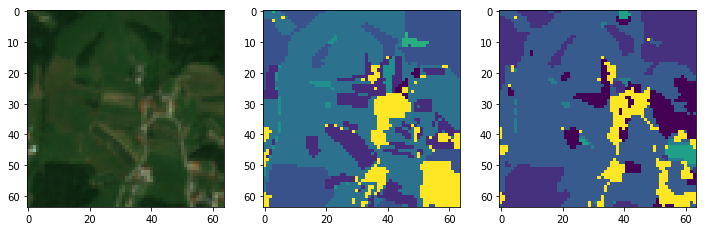

In [0]:
idx = 3
p = np.argmax(model.predict(np.array([x_test[idx]])), axis=3)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(x_test[idx])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(y_test[idx][:,:,0])
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(p[0])

In [0]:
import matplotlib as mpl
import numpy as np

lulc_cmap = mpl.colors.ListedColormap(['grey','yellow','green','lightgreen','brown','blue'])
lulc_cmap.set_over('grey')
lulc_cmap.set_under('grey')

bounds = np.arange(-0.5, 6, 1).tolist()
lulc_norm = mpl.colors.BoundaryNorm(bounds, lulc_cmap.N)

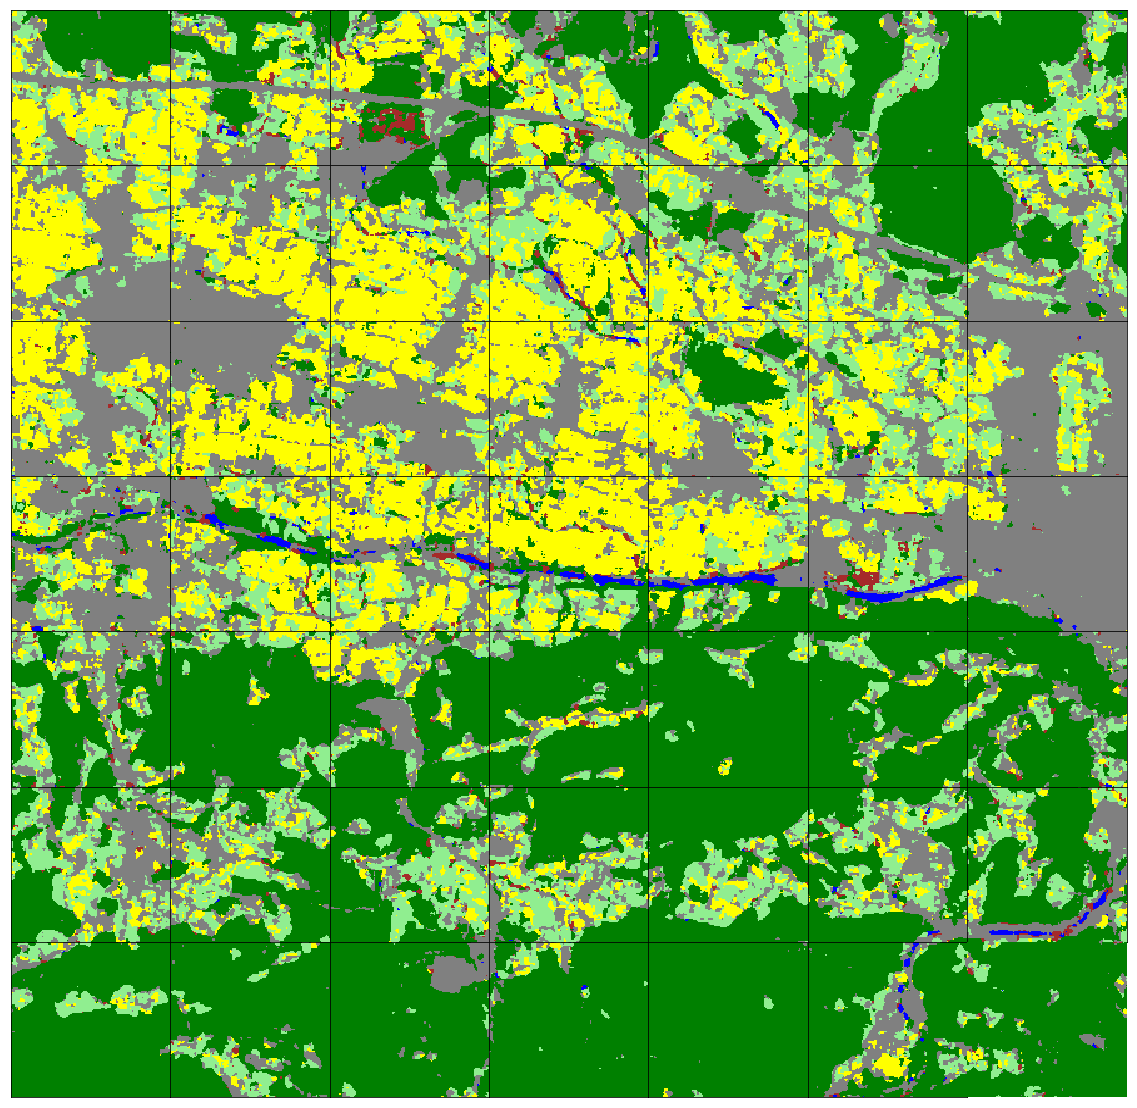

In [0]:


fig, axes = plt.subplots(figsize=(20,20), nrows=7, ncols=7)
plt.axis('off')
pbar = tqdm(total=49)                                                                   
for i, ax in enumerate(axes.flat):
    im = ax.imshow(np.argmax(model1.predict(np.array([x_test_raw[i]])), axis=3).squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    plt.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [0]:
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label',xlabel='Predicted label',filename=None):

    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap='GnBu', vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)

In [0]:
model = joblib.load('CNN_05.26.2019.pkl')

NameError: ignored

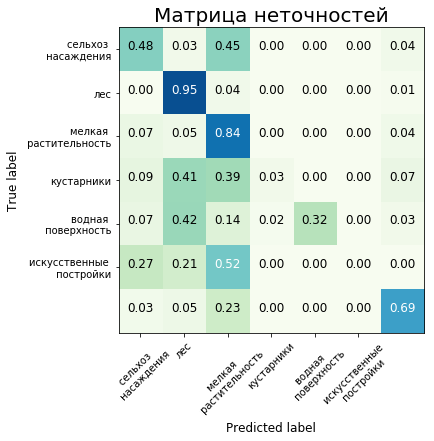

In [0]:
fig = plt.figure(figsize=(6, 6))
predictions = np.argmax(model.predict(x_test), axis=3)
cnf_matrix = confusion_matrix([int(x) for x in y_test.reshape(len(y_test) * 256 * 256, 1)], 
                              predictions.reshape(len(predictions) * 256 * 256, 1))
#cnf_matrix = cnf_matrix[1:,1:]
#cnf_matrix = np.concatenate((cnf_matrix[:6,:],cnf_matrix[7:,:]),axis=0)
#print(cnf_matrix.shape)
#cnf_matrix = np.concatenate((cnf_matrix[:,:6],cnf_matrix[:,7:]),axis=1)

plot_confusion_matrix(cnf_matrix, classes=['сельхоз \n насаждения',"лес","мелкая \n растительность", "кустарники", "водная \n поверхность","искусственные \n постройки"], normalize=True,title='Матрица неточностей')


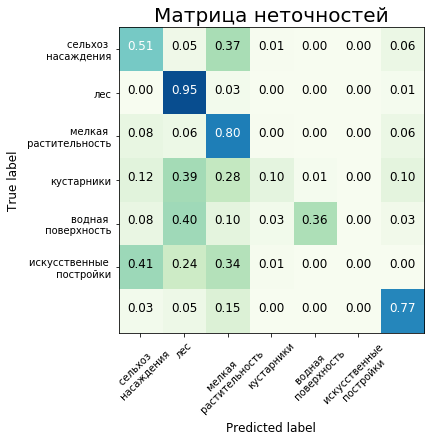

In [0]:
fig = plt.figure(figsize=(6, 6))
predictions = np.argmax(model.predict(x_test), axis=3)
cnf_matrix = confusion_matrix([int(x) for x in y_test.reshape(len(y_test) * 256 * 256, 1)], 
                              predictions.reshape(len(predictions) * 256 * 256, 1))
#cnf_matrix = cnf_matrix[1:,1:]
#cnf_matrix = np.concatenate((cnf_matrix[:6,:],cnf_matrix[7:,:]),axis=0)
#print(cnf_matrix.shape)
#cnf_matrix = np.concatenate((cnf_matrix[:,:6],cnf_matrix[:,7:]),axis=1)

plot_confusion_matrix(cnf_matrix, classes=['сельхоз \n насаждения',"лес","мелкая \n растительность", "кустарники", "водная \n поверхность","искусственные \n постройки"], normalize=True,title='Матрица неточностей')


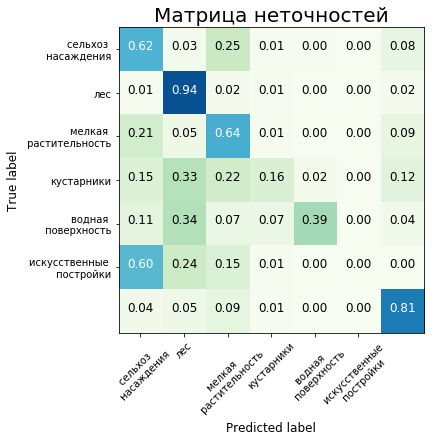

In [0]:
fig = plt.figure(figsize=(6, 6))
predictions = np.argmax(model.predict(x_test), axis=3)
cnf_matrix = confusion_matrix([int(x) for x in y_test.reshape(len(y_test) * 256 * 256, 1)], 
                              predictions.reshape(len(predictions) * 256 * 256, 1))
#cnf_matrix = cnf_matrix[1:,1:]
#cnf_matrix = np.concatenate((cnf_matrix[:6,:],cnf_matrix[7:,:]),axis=0)
#print(cnf_matrix.shape)
#cnf_matrix = np.concatenate((cnf_matrix[:,:6],cnf_matrix[:,7:]),axis=1)

plot_confusion_matrix(cnf_matrix, classes=['сельхоз \n насаждения',"лес","мелкая \n растительность", "кустарники", "водная \n поверхность","искусственные \n постройки"], normalize=True,title='Матрица неточностей')


(6, 7)


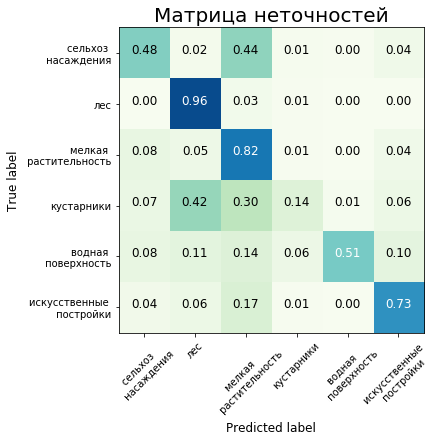

In [0]:
fig = plt.figure(figsize=(6, 6))
predictions = np.argmax(model.predict(x_test), axis=3)
cnf_matrix = confusion_matrix([int(x) for x in y_test.reshape(len(y_test) * 64 * 64, 1)], 
                              predictions.reshape(len(predictions) * 64 * 64, 1))
cnf_matrix = cnf_matrix[1:,1:]
cnf_matrix = cnf_matrix[:7,:7]
cnf_matrix = np.concatenate((cnf_matrix[:5,:],cnf_matrix[6:,:]),axis=0)
print(cnf_matrix.shape)
cnf_matrix = np.concatenate((cnf_matrix[:,:5],cnf_matrix[:,6:]),axis=1)

plot_confusion_matrix(cnf_matrix, classes=['сельхоз \n насаждения',"лес","мелкая \n растительность", "кустарники", "водная \n поверхность","искусственные \n постройки"], normalize=True,title='Матрица неточностей')


In [0]:
plabels_test = np.argmax(model.predict(x_test), axis=3).reshape(len(predictions) * 64 * 64, 1)
labels_test = [int(x) for x in y_test.reshape(len(y_test) * 64 * 64, 1)]

In [0]:
print('Classification accuracy {:.1f}%'.format(100*metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100*metrics.f1_score(labels_test, plabels_test, average='weighted')))

Classification accuracy 82.8%
Classification F1-score 81.9%


In [0]:
from sklearn import metrics

In [0]:
class_labels = np.unique(labels_test)
class_names = list(raster_value.keys())

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx]*100, 
                                                                         recall[idx]*100, 
                                                                         precision[idx]*100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * no_data              = 0.8 |  0.4  | 6.0
         * cultivated land      = 55.9 |  47.7  | 67.4
         * forest               = 95.3 |  96.2  | 94.4
         * grassland            = 74.7 |  81.6  | 68.8
         * schrubland           = 19.4 |  13.7  | 32.8
         * water                = 61.3 |  50.9  | 76.9
         * wetland              = 0.0 |  0.0  | 0.0
         * artificial surface   = 73.3 |  73.3  | 73.4
